## Eksplorativna i statistička analiza novosadskih kompanija prema zvaničnim podacima iz finansijskih izveštaja za 2024. godinu

Ova analiza predstavlja eksplorativni i statistički pregled poslovanja aktivnih društava sa ograničenom odgovornošću (DOO) sa sedištem u Novom Sadu, zasnovan na finansijskim izveštajima za 2024. godinu. Izvor podataka je Agencija za privredne registre (APR), a analiza obuhvata isključivo jednu kalendarsku godinu i jednu geografsku lokaciju, zbog čega vremenska i prostorna dimenzija nisu predmet razmatranja.

Obuhvaćeni su kvantitativni i kvalitativni pokazatelji poslovanja preduzeća, uz korišćenje atributa poput prihoda, neto dobiti, broja zaposlenih, bonitetne ocene i drugih relevantnih podataka. Na osnovu njih razvijeni su dodatni finansijski pokazatelji – poput profitnih i operativnih marži, prihoda po zaposlenom i pokazatelja koji posredno ukazuju na nivo kapitalnih ulaganja – koji omogućavaju identifikaciju obrazaca i razlika u poslovanju između sektora i pojedinačnih kompanija.

Cilj analize je da se stekne uvid u strukturu, snagu i karakteristike tržišta Novog Sada, kao i da se identifikuju ključni faktori koji oblikuju njegovu ekonomsku dinamiku.

### U IZRADI

In [1420]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import seaborn as sns

from scipy.stats import zscore, f_oneway
from sklearn.linear_model import LinearRegression

pd.set_option("display.float_format", "{:.2f}".format)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Podaci o novosadskim kompanijama prema podacima iz finansijskih izveštaja za 2024. godinu.

In [1421]:
df = pd.read_parquet("data/novi_sad_2024.parquet")

DataFrame šifara i opisa delatnosti srpske privrede.

In [1422]:
delatnosti_df = pd.read_parquet("data/delatnosti.parquet")

Funkcije

In [1423]:
def thousands_separator(x, pos):
    return f'{x:,.0f}'.replace(',', '.')

### 1. OSNOVNE INFORMACIJE O DATASETU

In [1424]:
df.shape

(3327, 23)

In [1425]:
df.columns

Index(['MB', 'PIB', 'Datum osnivanja', 'Naziv preduzeća', 'Mesto',
       'Poštanski broj', 'Adresa', 'Telefon', 'Pravni oblik',
       'Šifra delatnosti', 'Naziv delatnosti', 'APR Status', 'NBS Status',
       'Bonitetna ocena', 'Veličina', 'Promet (EUR)', 'Neto dobit (EUR)',
       'Broj zaposlenih', 'Ebit (EUR)', 'Ebitda (EUR)', 'Email', 'Zastupnik',
       'PDV Obveznik'],
      dtype='object')

In [1426]:
df.isna().sum()

MB                     0
PIB                    0
Datum osnivanja        0
Naziv preduzeća        0
Mesto                  0
Poštanski broj         0
Adresa                 0
Telefon             1856
Pravni oblik           0
Šifra delatnosti       0
Naziv delatnosti       0
APR Status             0
NBS Status             0
Bonitetna ocena        0
Veličina               2
Promet (EUR)           0
Neto dobit (EUR)       0
Broj zaposlenih        0
Ebit (EUR)             0
Ebitda (EUR)           0
Email                 98
Zastupnik              3
PDV Obveznik         833
dtype: int64

### 2. ČIŠĆENJE PODATAKA

Postupak pripreme podataka:
- 2.A Uklonjene su kolone koje sadrže kontakt informacije i podaci koji nisu relevantni za analizu.
- 2.B Izbrisana su dva zapisa kod kojih veličina preduzeća nije određena.
- 2.C Preimenovanje kolona radi lakšeg pozivanja i obrade atributa.
- 2.D Svođenje delatnosti na sektor i industrijski nivo.
- 2.E Uklonjene su kompanije sa prijavljenim prihodom od 0.
- 2.F Uklonjene su kompanije bez zaposlenih.
- 2.G Datum osnivanja konvertovan je u godinu, a dodat je i atribut dekade osnivanja.

2.A Uklonjene su kolone koje sadrže kontakt informacije i podaci koji nisu relevantni za analizu.i.

In [1427]:
columns_to_remove = [
    'MB', 'PIB','Mesto','Poštanski broj', 'Adresa', 'Telefon', 'Pravni oblik','Naziv delatnosti', 'APR Status', 'NBS Status','Email', 'Zastupnik',
       'PDV Obveznik']

df_cleaned = df.drop(columns=columns_to_remove)

2.B Izbrisana su dva zapisa kod kojih veličina preduzeća nije određena.

In [1428]:
df_cleaned = df_cleaned[df_cleaned['Veličina'].notna()]

2.C Preimenovanje kolona radi lakšeg pozivanja i obrade atributa.

In [1429]:
columns_rename_map = {
    "Datum osnivanja": "godina_osnivanja",
    'Naziv preduzeća': 'naziv',
    'Šifra delatnosti':'sifra_delatnosti',
    'Bonitetna ocena':'bonitet',
    'Veličina': 'velicina',
    'Promet (EUR)': 'prihod',
    'Neto dobit (EUR)': 'neto_dobit',
    'Broj zaposlenih': 'broj_zaposlenih',
    'Ebit (EUR)': 'ebit',
    'Ebitda (EUR)': 'ebitda'
}

df_cleaned = df_cleaned.rename(columns=columns_rename_map)

delatnosti_df = delatnosti_df.rename(columns={'CODE':'sifra','LAT': 'opis'})

df_cleaned.columns

Index(['godina_osnivanja', 'naziv', 'sifra_delatnosti', 'bonitet', 'velicina',
       'prihod', 'neto_dobit', 'broj_zaposlenih', 'ebit', 'ebitda'],
      dtype='object')

2.D Svođenje delatnosti na sektor i industrijski nivo.

In [1430]:
# Dodavanje vodeće nule ako je potrebno
df_cleaned['sifra_delatnosti'] = df_cleaned['sifra_delatnosti'].astype(str).str.zfill(4)

# Svođenje delatnosti na sektor i industrijski nivo
df_cleaned['sektor'] = df_cleaned['sifra_delatnosti'].str[:2]
df_cleaned.rename(columns={'sifra_delatnosti': 'industrija'}, inplace=True)

2.E Uklonjene su kompanije sa prijavljenim prihodom od 0.

In [1431]:
df_cleaned = df_cleaned[df_cleaned['prihod'] > 0]

2.F Uklonjene su kompanije bez zaposlenih.

In [1432]:
df_cleaned = df_cleaned[df_cleaned['broj_zaposlenih'] > 0]

2.G Datum osnivanja konvertovan je u godinu, a dodat je i atribut dekade osnivanja.

In [1433]:
df_cleaned['godina_osnivanja'] = pd.to_datetime(df_cleaned['godina_osnivanja'], format='%d.%m.%Y').dt.year
df_cleaned['dekada_osnivanja'] = (df_cleaned['godina_osnivanja'] // 10) * 10

In [1434]:
df_cleaned.sample(n=5, random_state=42)

,godina_osnivanja,naziv,industrija,bonitet,velicina,prihod,neto_dobit,broj_zaposlenih,ebit,ebitda,sektor,dekada_osnivanja
1720,2003,PROOF-CLEAN,4743,C2,Mikro,18595,-41199,1,-11955,-11819,47,2000
200,2016,SYNERGY AGRO DOO NOVI SAD,0146,C1,Malo,2055789,35721,4,172943,196265,01,2010
244,1987,PSS POLJOPRIVREDNA STANICA DOO NOVI SAD,7219,B1,Malo,1574030,176011,42,218613,262752,72,1980
2401,2020,NOBU TECHWAY,7311,D3,Mikro,63778,811,5,-6964,-3512,73,2020
1710,2024,MARHI CUBE DOO,7112,B1,Mikro,19988,7887,1,9280,9280,71,2020


### 3. KONSTRUKCIJA DODATNIH KARAKTERISTIKA (feature engineering)

Postupak:
- 3.A Izračunavanje operativnih rashoda
- 3.B Izračunavanje vrednosti amortizacije
- 3.C Izračunavanje profitnih marži (neto marža, EBIT marža, EBITDA marža)
- 3.D Izračunavanje marže amortizacije
- 3.E Izračunavanje marže kamata i poreza

In [1435]:
df_features = df_cleaned.copy().reset_index(drop=True)
del df_cleaned

#### 3.A Izračunavanje operativnih rashoda

Operativni rashodi predstavljaju ukupne troškove poslovanja koji nastaju tokom osnovne poslovne aktivnosti, bez uzimanja u obzir amortizacije, kamata i poreza. Izračunavaju se kao razlika između prihoda i EBITDA. Omogućavaju detaljniji uvid u troškove koji se direktno odnose na proizvodne i operativne procese. Upoređujući operativne rashode među različitim kompanijama, možemo steći uvid u efikasnost njihovih operacija i način upravljanja troškovima.

In [1436]:
df_features['operativni_rashodi'] = round(df_features.prihod - df_features.ebitda, 2)

#### 3.B. Vrednost amortizacije

Amortizacija predstavlja raspodelu troška kapitalnih ulaganja kroz vreme i obuhvata smanjenje vrednosti dugoročne imovine. Izračunava se kao razlika između EBITDA i EBIT, međutim, važno je napomenuti da vrednost amortizacije ne ukazuje direktno na visinu kapitalnih ulaganja, jer zavisi od primenjenih metoda amortizacije i korišćenja različitih amortizacionih stopa. Analizirajući vrednost amortizacije, možemo dobiti okvirnu informaciju o kapitalnoj intenzivnosti poslovanja kompanije i uočiti kako njena ulaganja u imovinu utiču na finansijske performanse. Upoređujući amortizaciju među kompanijama ili sektorima, moguće je primetiti razlike u pristupima kapitalnim ulaganjima, kao i njihovim efektima na profitabilnost.

In [1437]:
df_features['amortizacija'] = round(df_features.ebitda - df_features.ebit, 2)

#### 3.C. Marže

##### 3.C.1. Neto marža

Neto marža pokazuje koliko profita ostaje od svakih 100 jedinica prihoda nakon što se oduzmu svi troškovi, porezi i kamate. Upoređujući neto marže između kompanija, možemo utvrditi koja je kompanija efikasnija u konverziji prihoda u čist profit.

In [1438]:
df_features['net_marza'] = round(df_features.neto_dobit / df_features.prihod, 2)

##### 3.C.2. EBIT marža

EBIT marža pokazuje koliko od svaka 100 jedinica prihoda ostaje nakon operativnih troškova, pre kamata i poreza. Viša EBIT marža pokazuje da je kompanija efikasnija u generisanju profita iz osnovne delatnosti.

In [1439]:
df_features['ebit_marza'] = round(df_features.ebit / df_features.prihod, 2)

##### 3.C.3. EBITDA marža

Upoređivanje EBITDA marže pomaže u proceni koja kompanija ima bolju osnovnu operativnu efikasnost, pre nego što se oduzmu negotovinski troškovi kao što je amortizacija. Ovo je posebno korisno za upoređivanje kompanija sa različitim strukturama kapitala ili onih koje posluju u industrijama koje zahtevaju velika ulaganja u opremu, infrastrukturu i dugoročne resurse, kao što su industrija proizvodnje, energetika, telekomunikacije i građevina.

In [1440]:
df_features['ebitda_marza'] = round(df_features.ebitda / df_features.prihod, 2)

##### 3.C.4. Marža amortizacije

Razlika između EBITDA i EBIT, izražena kao procenat prihoda, pokazuje koliki deo ostvarenog prihoda se troši na amortizaciju osnovnih sredstava. Ova marža daje uvid u stepen zavisnosti poslovanja od dugotrajne imovine, poput opreme, mašina i objekata. Viša marža ukazuje na kapitalno intenzivnije poslovanje i veća ulaganja u imovinu koja se vremenom troši.

In [1441]:
df_features['marza_amortizacije'] = round((df_features.ebitda - df_features.ebit) / df_features.prihod * 100, 2)

##### 3.C.5. Marža kamata i poreza

Razlika između EBIT-a i neto profita pokazuje koliki iznos prihoda se troši na kamate i poreze. Ovaj podatak može pružiti uvid u finansijsko i poresko opterećenje poslovanja. Veći iznosi mogu ukazivati na veće dugove ili viši poreski teret, što utiče na konačnu profitabilnost. Međutim, rezultati ove analize treba da se uzmu sa rezervom, jer se ne može direktno izračunati nivo zaduženosti preduzeća, a razlika može biti pod uticajem različitih računovodstvenih metoda.

Ipak, posredno, ovakva marža može ukazivati na intenzitet zaduženosti sektora, jer veće kamate i porezi često reflektuju veći nivo duga u odnosu na kapital. Ova analiza može pomoći u identifikaciji sektora sa većim ili manjim zaduženjem, ali samo kao okvirna procena.

In [1442]:
df_features['marza_kamate_poreza'] = round((df_features.ebit - df_features.neto_dobit) / df_features.prihod * 100, 2)

In [1443]:
df_features.columns

Index(['godina_osnivanja', 'naziv', 'industrija', 'bonitet', 'velicina',
       'prihod', 'neto_dobit', 'broj_zaposlenih', 'ebit', 'ebitda', 'sektor',
       'dekada_osnivanja', 'operativni_rashodi', 'amortizacija', 'net_marza',
       'ebit_marza', 'ebitda_marza', 'marza_amortizacije',
       'marza_kamate_poreza'],
      dtype='object')

### 4. EKSPLORATIVNA, STATISTIČKA ANALIZA I VIZUELIZACIJA REZULTATA

PRIPREMA PODATAKA

Napomena o interpretaciji rezultata: 
Sve analize u ovom projektu imaju za cilj da istraže povezanost između pojedinačnih poslovnih pokazatelja kompanija iz Novog Sada. Iako određeni rezultati pokazuju statistički značajne povezanosti, važno je naglasiti da ove analize ne određuju uzročno-posledične odnose, niti identifikuju presudne faktore. Prikazani rezultati pružaju uvid u obrasce koji zaslužuju dodatnu, dublju analizu, uključujući i druge finansijske, operativne i tržišne aspekte poslovanja.

Pored ograničenja u interpretaciji uzročno-posledičnih odnosa, važno je napomenuti da pojedine informacije nisu direktno dostupne u skupu podataka, već su izvedene na osnovu dostupnih finansijskih pokazatelja, zato njihovu tačnost treba tumačiti uslovno, imajući u vidu ograničenja izvora podataka.

Iznosi su u hiljadama RSD.

#### Sadržaj:

- 4.A PREGLED DISTRIBUCIJE KOMPANIJA PO BROJČANOSTI — ZAVRŠENO
    - 4.A.1 Prema veličini
    - 4.A.2 Prema bonitetu
    - 4.A.3 Prema dekadi osnivanja

- 4.B SEKTORI PRIVREDE — ZAVRŠENO
    - 4.B.1 Najzastupljeniji sektori novosadskih kompanija
    - 4.B.2 Najzastupljeniji sektori novosadskih kompanija prema veličini kompanije
    - 4.B.3 Sektori sa najvišim i najnižim prosečnim prihodima
    - 4.B.4 Sektori sa najvišim i najnižim prihodima po zaposlenom
    - 4.B.5 Sektori sa najvišim i najnižim prosečnim operativnim rashodima
    - 4.B.6 Najprofitabilniji i najmanje profitabilni sektori
    - 4.B.7 Sektori sa najvišim i najnižim neto maržama
    - 4.B.8 Sektori sa najvišim i najnižom prosečnom amortizacijom
    - 4.B.9 Poređenje profitabilnosti proizvodnih i uslužnih sektora
    - 4.B.10 Pregled informacija izabranog sektoru

- 4.C PRIHODI — ZAVRŠENO
    - 4.C.1 Logaritamski raspoređena distribucija prihoda po intervalima
    - 4.C.2 (ANOVA) Prihodi prema veličini kompanije
    - 4.C.3 Povezanost prihoda i broja zaposlenih
    - 4.A.4 Identifikacija sektora sa najvišim i najnižim prihodima
    - 4.C.5 Analiza izolovanih slučajeva (outlier analiza)

- 4.D RASHODI
    - 4.D.1 Distribucija rashoda
    - 4.D.2 Rashodi prema veličini kompanije
    - 4.D.3 Analiza izolovanih slučajeva (outlier analiza)

- 4.E NETO DOBIT
    - 4.E.1 Neto dobit i broj zaposlenih
    - 4.E.2 Pregled 10 najprofitabilnijih novosadskih kompanija i sektor kojima pripadaju
    - 4.E.3 Grupisanje profitabilnosti i veličine kompanija
    - 4.E.4 Distribucija profita po intervalima
    - 4.E.5 Analiza izolovanih slučajeva (outlier): kompanije sa ekstremno visokim prihodom, ali niskom neto maržom

- 4.F POSLOVNE MARŽE
    - 4.F.1 Neto marža: dekada osnivanja, sektor i industrija poslovanja.
    - 4.E.4 Distribucija neto marže po intervalima
    - 4.F.2 EBIT marža: veličina, bonitet, sektor i industrija poslovanja.
    - 4.F.3 EBITDA marža: veličina, bonitet, sektor i industrija poslovanja.
    - 4.F.4 Marža amortizacije: veličina, bonitet, sektor poslovanja.
    - 4.F.5 Marža kamate i poreza. veličina i sektor poslovanja.
    - 4.F.6 Marža kamate i poreza prema industriji poslovanja
    - 4.F.7 Najuticajniji faktori na vrednost neto marže (npr. veličina kompanije, sektor, kapitalna ulaganja, broj zaposlenih)

- 4.G AMORTIZACIJA I MARŽA AMORTIZACIJE
    - 4.F.1 Povezanost kapitalnih ulaganja i proizvodnih/sulužnih sektora
    - 4.F.2 Prosečan neto povraćaj na kapitalna ulaganja (KPI: neto_dobit / amortizacija).
    - 4.F.3 Vrednost kapitalnih ulaganja po sektoru
    - 4.F.4 Poređenje povezanosti amortizacije i proizvodnih/sulužnih sektora

- 4.H ZAPOSLENI
    - 4.H.1 Prosečan broj zaposlenih prema industriji i sektoru poslovanja.
    - 4.H.2 Test normalne distribucije zaposlenih po prihodima.
    - 4.H.3 Prosečan broj zaposlenih prema bonitetnom skoru.
    - 4.H.4 Prosečan broj zaposlenih prema dekadi osnivanja.

- 4.I OSTALO (komparativna analiza)
    - 4.I.1 Performanse novih vs. starijih kompanija

- 5 KLASTER ANALITA


In [1444]:
df_analysis = df_features.copy().reset_index(drop=True)

#### 4.A PREGLED DISTRIBUCIJE KOMPANIJA PO BROJČANOSTI

Ovim pregledima dobijamo uvid u brojčanu i strukturnu raspodelu kompanija u Novom Sadu. Prikazuje se kako su firme klasifikovane prema veličini, što otkriva zastupljenost mikro, malih, srednjih i velikih preduzeća u lokalnoj privredi. Analiza boniteta osvetljava finansijsku stabilnost firmi, dok raspodela po dekadama osnivanja pokazuje kada su nastajale kompanije,. Ukupno, ove analize služe kao polazna tačka za razumevanje poslovnog pejzaža grada.

4.A.1 Prema veličini

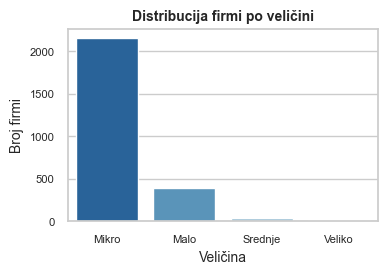

In [1445]:
plt.figure(figsize=(4, 2.5))
sns.countplot(
    data=df_analysis,
    x='velicina',
    palette='Blues_r',
    order=['Mikro', 'Malo', 'Srednje', 'Veliko'],
    legend=False
)

plt.title('Distribucija firmi po veličini', fontsize=10, fontweight='bold')
plt.xlabel('Veličina', fontsize=10)
plt.ylabel('Broj firmi', fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.show()

4.A.2 Prema bonitetu

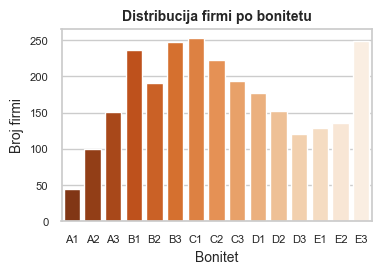

In [1446]:
plt.figure(figsize=(4, 2.5))
sns.countplot(
    data=df_analysis,
    x='bonitet',
    palette='Oranges_r',
    order=['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'C1', 'C2', 'C3', 'D1', 'D2', 'D3', 'E1', 'E2', 'E3'],
    legend=False
)

plt.title('Distribucija firmi po bonitetu', fontsize=10, fontweight='bold')
plt.xlabel('Bonitet', fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.ylabel('Broj firmi', fontsize=10)

plt.show()

4.A.3 Prema dekadi osnivanja

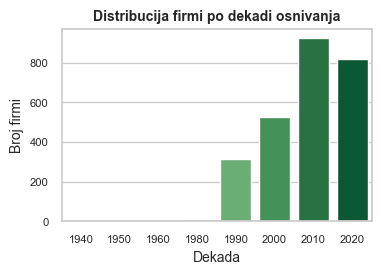

In [1447]:
plt.figure(figsize=(4, 2.5))
sns.countplot(
    data=df_analysis,
    x='dekada_osnivanja',
    palette='YlGn',
    legend=False
)

plt.title('Distribucija firmi po dekadi osnivanja', fontsize=10, fontweight='bold')
plt.xlabel('Dekada', fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.ylabel('Broj firmi', fontsize=10)

plt.show()

#### 4.B. SEKTOR I INDUSTRIJA

Obrada podataka za analizu sektora

In [1448]:
#1. Sektor count
sektor_df = df_analysis['sektor'].value_counts().reset_index()

#2. Sektor opis
sektor_df = sektor_df.merge(delatnosti_df[['sifra', 'opis']], left_on='sektor', right_on='sifra', how='left')
sektor_df['opis'] = "(" + sektor_df['sektor']  +") " + sektor_df['opis'].str.split('[,;]').str[0]
sektor_df.drop(columns=['sifra'], inplace=True)

#3. Zaposleni
sektor_df['broj_zaposlenih'] = sektor_df['sektor'].map(
    df_analysis.groupby('sektor')['broj_zaposlenih'].sum()
)

#4. Ukupni prihodi po sektoru
sektor_df['ukupni_prihod'] = sektor_df['sektor'].map(
    df_analysis.groupby('sektor')['prihod'].sum()
)

#5. Prosečni prihodi sektora
sektor_df['prosecni_prihod'] = sektor_df['sektor'].map(
    df_analysis.groupby('sektor')['prihod'].mean()
)

#6. Prosečan prihod po zaposlenom 
sektor_df['prihod_po_zaposlenom'] = sektor_df['ukupni_prihod'] / sektor_df['broj_zaposlenih']


#7. Prosečni operativni rashodi sektora
sektor_df['prosecni_operativni_rashodi'] = sektor_df['sektor'].map(
    df_analysis.groupby('sektor')['operativni_rashodi'].mean()
)

#8. Prosečna neto dobit sektora
sektor_df['prosecna_neto_dobit'] = sektor_df['sektor'].map(
    df_analysis.groupby('sektor')['neto_dobit'].mean()
)

#9. Prosečna neto marža sektora
sektor_df['prosecna_neto_marza'] = sektor_df['prosecna_neto_dobit'] / sektor_df['prosecni_prihod']

#10. Prosečna amortizacija (mediana) sektora
sektor_df['prosecna_amortizacija'] = sektor_df['sektor'].map(
    df_analysis.groupby('sektor')['amortizacija'].median()
)

sektor_df.sample(n=5, random_state=42)

,sektor,count,opis,broj_zaposlenih,ukupni_prihod,prosecni_prihod,prihod_po_zaposlenom,prosecni_operativni_rashodi,prosecna_neto_dobit,prosecna_neto_marza,prosecna_amortizacija
22,25,22,(25) Proizvodnja metalnih proizvoda,104,6276668,285303.09,60352.58,255516.27,17534.64,0.06,3414.50
0,46,472,(46) Trgovina na veliko,3469,1793179113,3799108.29,516915.28,3688231.10,56775.73,0.01,1696.00
49,27,6,(27) Proizvodnja električne opreme,4146,229612858,38268809.67,55381.78,35349287.17,1543395.83,0.04,3337.00
4,41,135,(41) Izgradnja zgrada,1318,312310568,2313411.61,236957.94,2094366.12,174342.12,0.08,2461.00
54,35,4,(35) Snabdevanje električnom energijom,9,811100,202775.00,90122.22,177281.00,-216069.00,-1.07,7772.50


4.B.1 Najzastupljeniji sektori novosadskih kompanija.

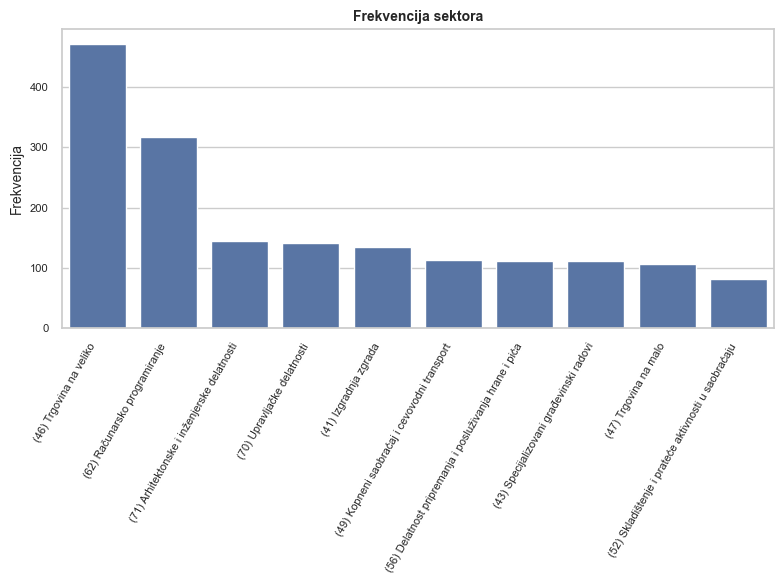

In [1449]:
sectors_count = sektor_df.head(10).reset_index(drop=True)

plt.figure(figsize=[8,6])

sns.barplot(data=sectors_count, x='opis', y='count')

plt.title('Frekvencija sektora', fontsize=10, fontweight='bold') 
plt.xlabel("")
plt.ylabel('Frekvencija', fontsize=10)
plt.xticks(rotation=60, ha='right', fontsize=8)
plt.yticks(fontsize=8)

plt.tight_layout()  
plt.show()

4.B.2 Najzastupljeniji sektori novosadskih kompanija prema veličini kompanije.

In [1450]:
result = (
    df_analysis.groupby(['velicina', 'sektor'])
    .size()
    .reset_index(name='broj')
    .sort_values(['velicina', 'broj'], ascending=[True, False])
    .groupby('velicina')
    .first()
    .reset_index()
)

sektor_opisi = {
    šifra: opis.split(',')[0]
    for šifra, opis in zip(delatnosti_df['sifra'], delatnosti_df['opis'])
}

output_opis = {
    velicina: (sektor_opisi.get(sektor), broj)
    for velicina, sektor, broj in zip(result['velicina'], result['sektor'], result['broj'])
}

for velicina, (sektor_opis, broj) in output_opis.items():
    print(f"VELIČINA: {velicina}, NAJZASTUPLJENIJI SEKTOR: {sektor_opis}, BROJ KOMPANIJA: {broj}")

VELIČINA: Malo, NAJZASTUPLJENIJI SEKTOR: Trgovina na veliko, BROJ KOMPANIJA: 96
VELIČINA: Mikro, NAJZASTUPLJENIJI SEKTOR: Trgovina na veliko, BROJ KOMPANIJA: 363
VELIČINA: Srednje, NAJZASTUPLJENIJI SEKTOR: Trgovina na veliko, BROJ KOMPANIJA: 10
VELIČINA: Veliko, NAJZASTUPLJENIJI SEKTOR: Trgovina na veliko, BROJ KOMPANIJA: 3


4.B.3 Sektori sa najvišim i najnižim prosečnim prihodima. 

Prikazuje sektore sa najvišim i najnižim prosečnim prihodima, omogućavajući uvid u to koje delatnosti generišu najveći obim poslovne aktivnosti. Za analizu je korišćena aritmetička sredina, što pruža jasniji prikaz prihoda i omogućava upoređivanje sektora na osnovu njihovog prihodnog potencijala.

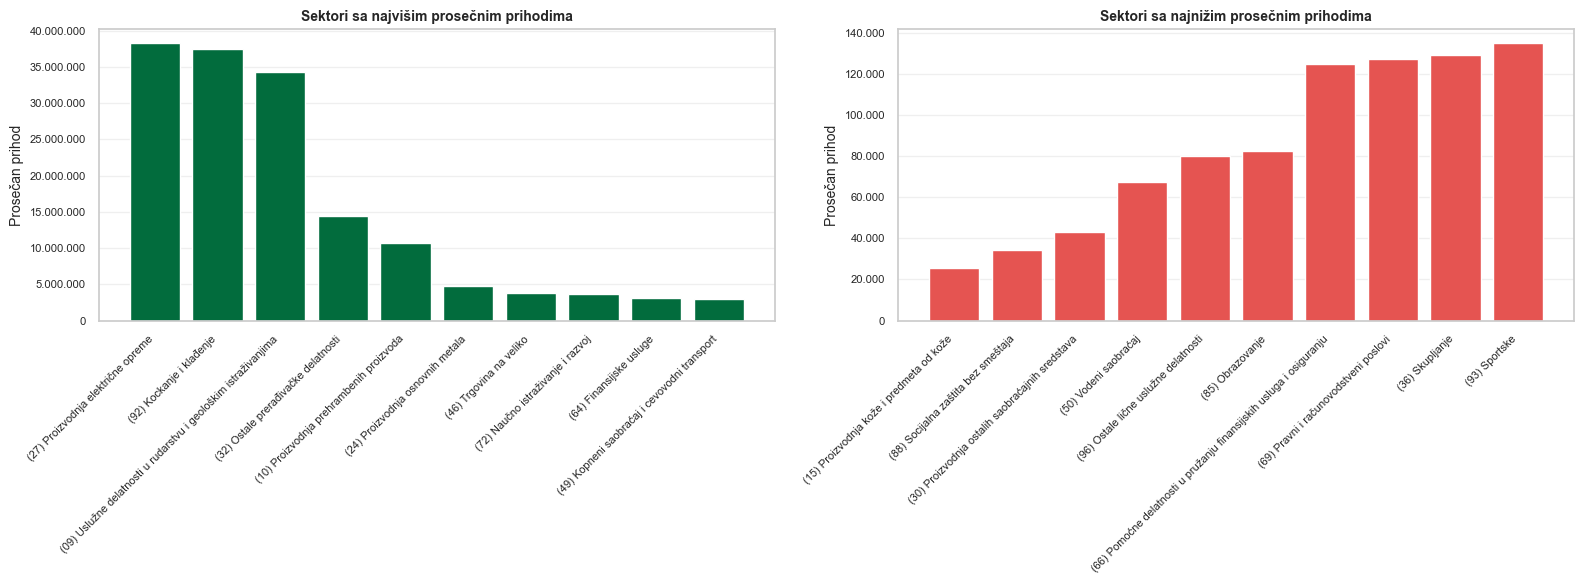

In [1451]:
top_revenue_sectors = sektor_df.sort_values('prosecni_prihod', ascending=False).head(10)
bottom_revenue_sectors = sektor_df.sort_values('prosecni_prihod', ascending=True).head(10)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.bar(top_revenue_sectors['opis'], top_revenue_sectors['prosecni_prihod'], color='#026C3D')
ax1.set_title('Sektori sa najvišim prosečnim prihodima', fontsize=10, fontweight='bold')
ax1.set_ylabel('Prosečan prihod', fontsize=10)
ax1.set_xticks(range(len(top_revenue_sectors['opis'])))
ax1.set_xticklabels(top_revenue_sectors['opis'], rotation=45, ha='right', fontsize=8)
ax1.tick_params(axis='y', labelsize=8)

ax1.yaxis.set_major_formatter(FuncFormatter(thousands_separator))
ax1.grid(False)
ax1.grid(axis='y', alpha=0.3)

ax2.bar(bottom_revenue_sectors['opis'], bottom_revenue_sectors['prosecni_prihod'], color='#E55451')
ax2.set_title('Sektori sa najnižim prosečnim prihodima', fontsize=10, fontweight='bold')
ax2.set_ylabel('Prosečan prihod', fontsize=10)
ax2.set_xticks(range(len(bottom_revenue_sectors['opis'])))
ax2.set_xticklabels(bottom_revenue_sectors['opis'], rotation=45, ha='right', fontsize=8)
ax2.tick_params(axis='y', labelsize=8)

ax2.yaxis.set_major_formatter(FuncFormatter(thousands_separator))
ax2.grid(False)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

4.B.4 Sektori sa najvišim i najnižim prihodima po zaposlenom.

Prikazuje efikasnost sektora kroz odnos ostvarenih prihoda i broja zaposlenih, odnosno koliko prihoduje prosečan zaposleni u određenom sektoru. Cilj je identifikovati sektore sa najvećom i najmanjom produktivnošću po zaposlenom.

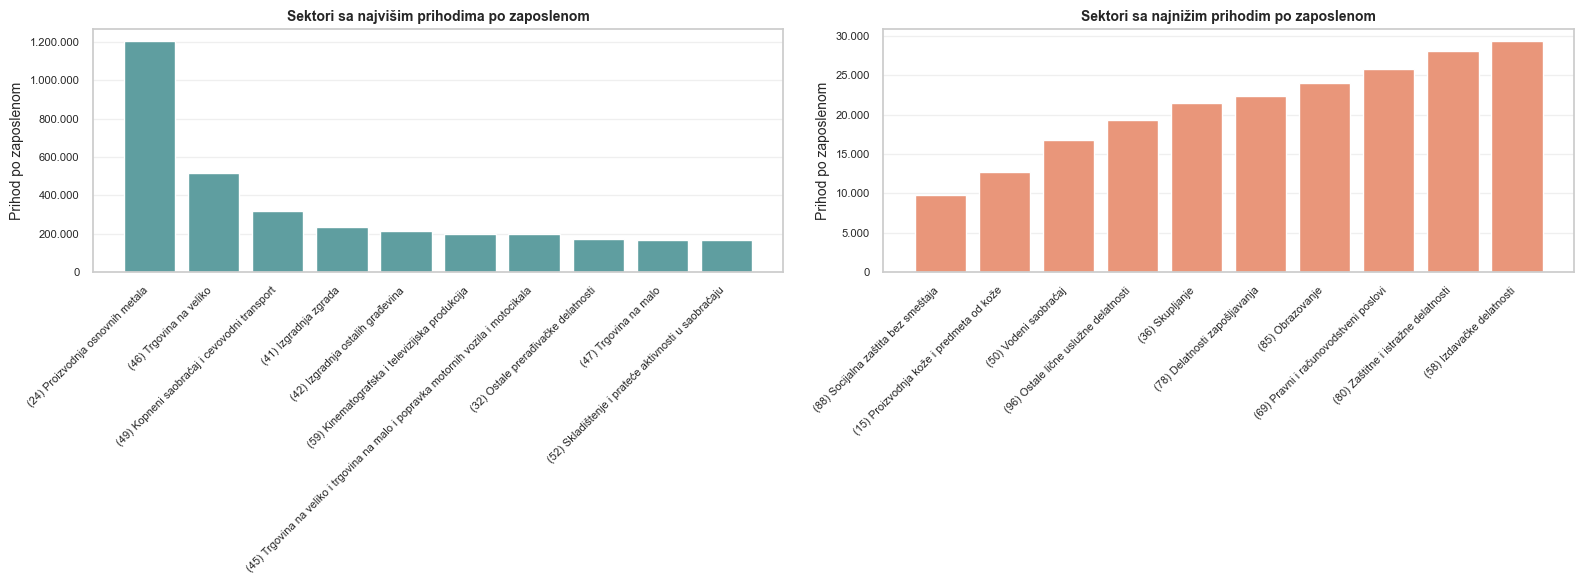

In [1452]:
top_rpe_sectors = sektor_df.sort_values('prihod_po_zaposlenom', ascending=False).head(10)
bottom_rpe_sectors = sektor_df.sort_values('prihod_po_zaposlenom', ascending=True).head(10)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.bar(top_rpe_sectors['opis'], top_rpe_sectors['prihod_po_zaposlenom'], color='CadetBlue')
ax1.set_title('Sektori sa najvišim prihodima po zaposlenom', fontsize=10, fontweight='bold')
ax1.set_ylabel('Prihod po zaposlenom', fontsize=10)
ax1.set_xticks(range(len(top_rpe_sectors['opis'])))
ax1.set_xticklabels(top_rpe_sectors['opis'], rotation=45, ha='right', fontsize=8)
ax1.tick_params(axis='y', labelsize=8)

ax1.yaxis.set_major_formatter(FuncFormatter(thousands_separator))

ax1.grid(False)
ax1.grid(axis='y', alpha=0.3)

ax2.bar(bottom_rpe_sectors['opis'], bottom_rpe_sectors['prihod_po_zaposlenom'], color='DarkSalmon')
ax2.set_title('Sektori sa najnižim prihodim po zaposlenom', fontsize=10, fontweight='bold')
ax2.set_ylabel('Prihod po zaposlenom', fontsize=10)
ax2.set_xticks(range(len(bottom_rpe_sectors['opis'])))
ax2.set_xticklabels(bottom_rpe_sectors['opis'], rotation=45, ha='right', fontsize=8)
ax2.tick_params(axis='y', labelsize=8)

ax2.yaxis.set_major_formatter(FuncFormatter(thousands_separator))

ax2.grid(False)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

4.B.5 Sektori sa najvišim i najnižim prosečnim operativnim rashodima.

Sektore sa najvišim i najnižim prosečnim operativnim rashodima, što omogućava uvid u efikasnost poslovanja u različitim delatnostima. Cilj je prepoznati oblasti sa visokim troškovima poslovanja i one koje ostvaruju veću operativnu efikasnost.

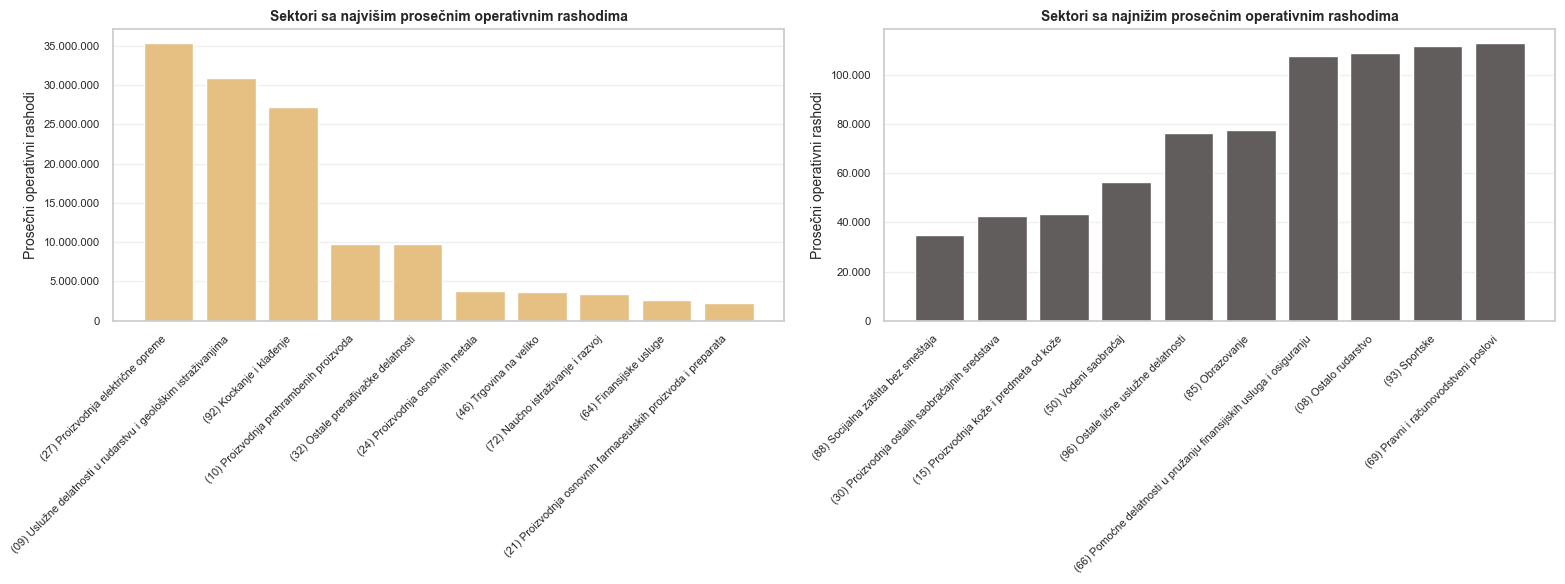

In [1453]:
top_rpexp_sectors = sektor_df.sort_values('prosecni_operativni_rashodi', ascending=False).head(10)
bottom_rpexp_sectors = sektor_df.sort_values('prosecni_operativni_rashodi', ascending=True).head(10)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.bar(top_rpexp_sectors['opis'], top_rpexp_sectors['prosecni_operativni_rashodi'], color='#E6BF83')
ax1.set_title('Sektori sa najvišim prosečnim operativnim rashodima', fontsize=10, fontweight='bold')
ax1.set_ylabel('Prosečni operativni rashodi', fontsize=10)
ax1.set_xticks(range(len(top_rpexp_sectors['opis'])))
ax1.set_xticklabels(top_rpexp_sectors['opis'], rotation=45, ha='right', fontsize=8)
ax1.tick_params(axis='y', labelsize=8)

ax1.yaxis.set_major_formatter(FuncFormatter(thousands_separator))

ax1.grid(False)
ax1.grid(axis='y', alpha=0.3)

ax2.bar(bottom_rpexp_sectors['opis'], bottom_rpexp_sectors['prosecni_operativni_rashodi'], color='#625D5D')
ax2.set_title('Sektori sa najnižim prosečnim operativnim rashodima', fontsize=10, fontweight='bold')
ax2.set_ylabel('Prosečni operativni rashodi', fontsize=10)
ax2.set_xticks(range(len(bottom_rpexp_sectors['opis'])))
ax2.set_xticklabels(bottom_rpexp_sectors['opis'], rotation=45, ha='right', fontsize=8)
ax2.tick_params(axis='y', labelsize=8)

ax2.yaxis.set_major_formatter(FuncFormatter(thousands_separator))

ax2.grid(False)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

4.B.6 Najprofitabilniji i najmanje profitabilni sektori.

Identifikuje najprofitabilnije i najmanje profitabilne sektore na osnovu neto dobiti, omogućavajući uvid u finansijsku uspešnost različitih sektora. 

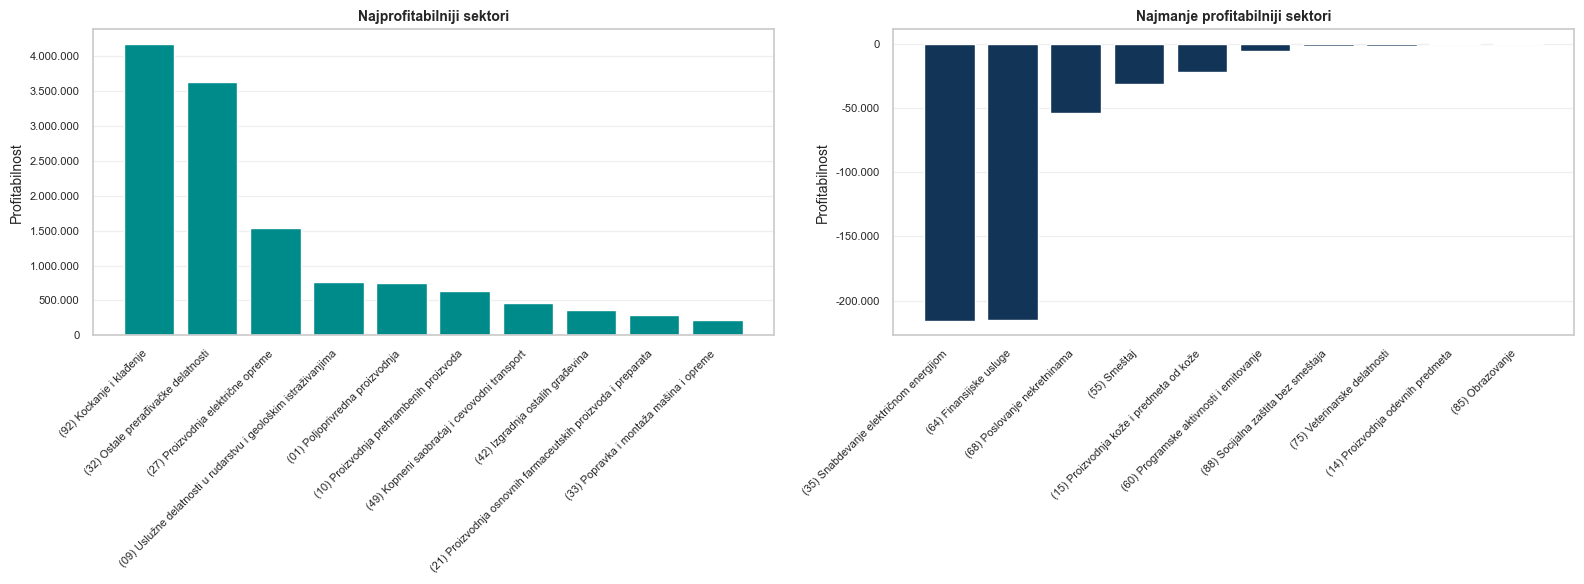

In [1454]:
top_nd_sectors = sektor_df.sort_values('prosecna_neto_dobit', ascending=False).head(10)
bottom_nd = sektor_df.sort_values('prosecna_neto_dobit', ascending=True).head(10)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.bar(top_nd_sectors['opis'], top_nd_sectors['prosecna_neto_dobit'], color='#008B8B')
ax1.set_title('Najprofitabilniji sektori', fontsize=10, fontweight='bold')
ax1.set_ylabel('Profitabilnost', fontsize=10)
ax1.set_xticks(range(len(top_nd_sectors['opis'])))
ax1.set_xticklabels(top_nd_sectors['opis'], rotation=45, ha='right', fontsize=8)
ax1.tick_params(axis='y', labelsize=8)

ax1.yaxis.set_major_formatter(FuncFormatter(thousands_separator))

ax1.grid(False)
ax1.grid(axis='y', alpha=0.3)

ax2.bar(bottom_nd['opis'], bottom_nd['prosecna_neto_dobit'], color='#123456')
ax2.set_title('Najmanje profitabilniji sektori', fontsize=10, fontweight='bold')
ax2.set_ylabel('Profitabilnost', fontsize=10)
ax2.set_xticks(range(len(bottom_nd['opis'])))
ax2.set_xticklabels(bottom_nd['opis'], rotation=45, ha='right', fontsize=8)
ax2.tick_params(axis='y', labelsize=8)

ax2.yaxis.set_major_formatter(FuncFormatter(thousands_separator))

ax2.grid(False)
ax2.grid(axis='y', alpha=0.3)


plt.tight_layout()
plt.show()

4.B.7 Sektori sa najvišim i najnižim prosečnim neto maržama. 

Prikazuje sektore sa najvišim i najnižim prosečnim neto maržama, pružajući uvid u profitabilnost različitih delatnosti. Ovaj pregled omogućava upoređivanje sektora na osnovu njihove sposobnosti da ostvaruju profit u odnosu na ukupne prihode, što je ključno za procenu efikasnosti poslovanja.

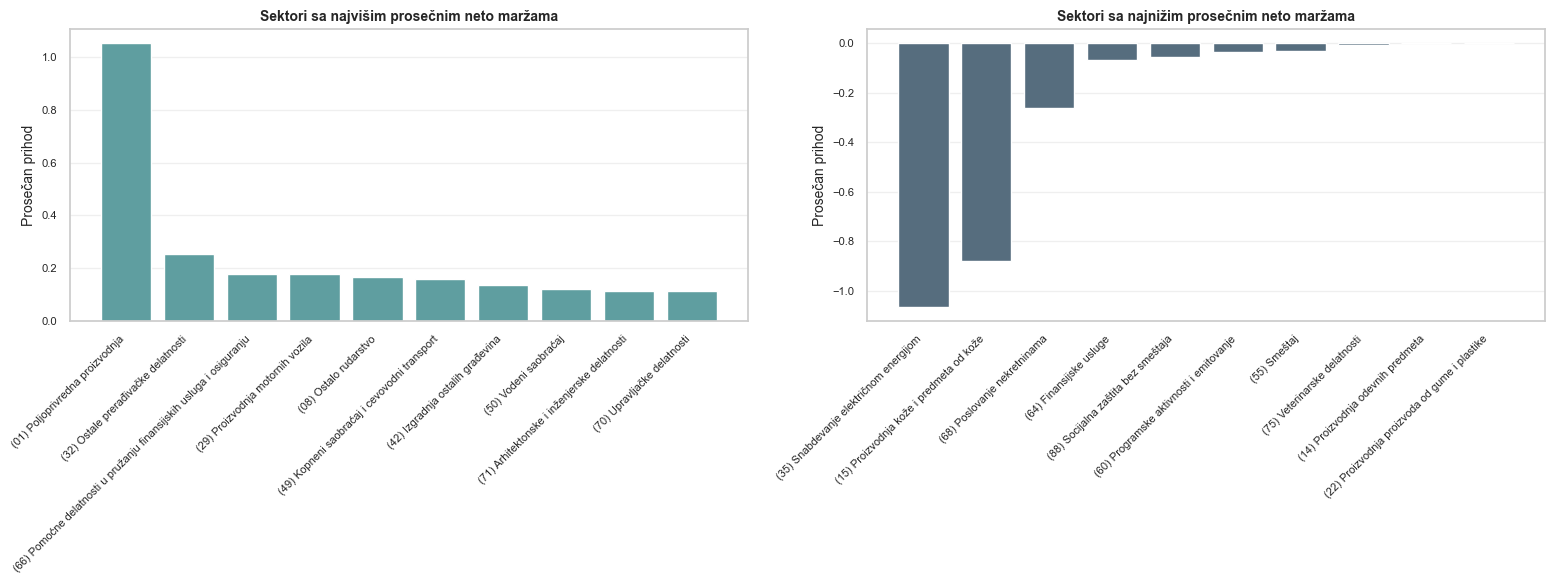

In [1455]:
top_nm_sectors = sektor_df.sort_values('prosecna_neto_marza', ascending=False).head(10)
bottom_nm_sectors = sektor_df.sort_values('prosecna_neto_marza', ascending=True).head(10)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.bar(top_nm_sectors['opis'], top_nm_sectors['prosecna_neto_marza'], color='#5F9EA0')
ax1.set_title('Sektori sa najvišim prosečnim neto maržama', fontsize=10, fontweight='bold')
ax1.set_ylabel('Prosečan prihod', fontsize=10)
ax1.set_xticks(range(len(top_nm_sectors['opis'])))
ax1.set_xticklabels(top_nm_sectors['opis'], rotation=45, ha='right', fontsize=8)
ax1.tick_params(axis='y', labelsize=8)

ax1.grid(False)
ax1.grid(axis='y', alpha=0.3)

ax2.bar(bottom_nm_sectors['opis'], bottom_nm_sectors['prosecna_neto_marza'], color='#566D7E')
ax2.set_title('Sektori sa najnižim prosečnim neto maržama', fontsize=10, fontweight='bold')
ax2.set_ylabel('Prosečan prihod', fontsize=10)
ax2.set_xticks(range(len(bottom_nm_sectors['opis'])))
ax2.set_xticklabels(bottom_nm_sectors['opis'], rotation=45, ha='right', fontsize=8)
ax2.tick_params(axis='y', labelsize=8)

ax2.grid(False)
ax2.grid(axis='y', alpha=0.3)

ax1.ticklabel_format(style='plain', axis='y')
ax2.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

4.B.8. Sektori sa najvišom i najnižom amortizacijom

Prikazuje sektore sa najvišom i najnižom amortizacijom, koja se koristi kao pokazatelj kapitalno intenzivnog poslovanja. Za analizu je korišćena medijana, jer ona daje precizniji uvid u amortizaciju, posebno u slučajevima kada postoji veliki broj ekstremenih vrednosti koje mogu uticati na prosečan rezultat. Medijana omogućava realniji prikaz centralne tendencije, bez uticaja neobičnih vrednosti.

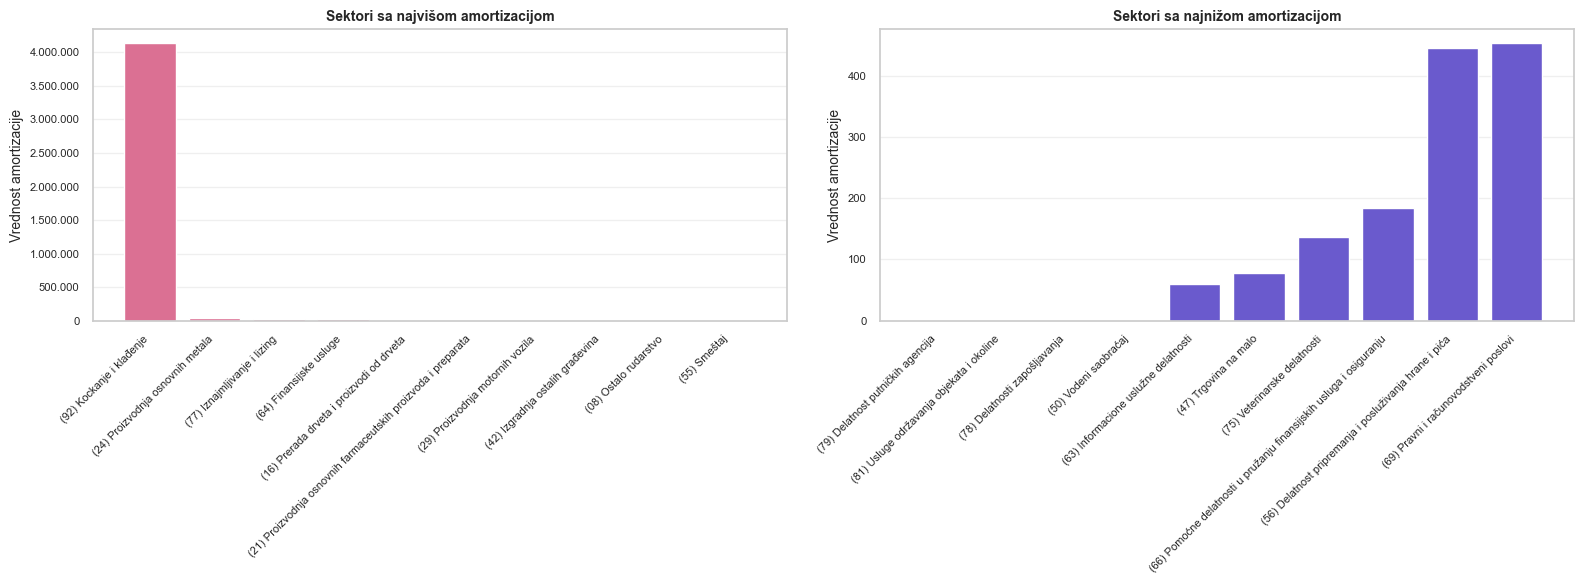

In [1456]:
top_amort_sectors = sektor_df.sort_values('prosecna_amortizacija', ascending=False).head(10)
bottom_amort_sectors = sektor_df.sort_values('prosecna_amortizacija', ascending=True).head(10)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.bar(top_amort_sectors['opis'], top_amort_sectors['prosecna_amortizacija'], color='PaleVioletRed')
ax1.set_title('Sektori sa najvišom amortizacijom', fontsize=10, fontweight='bold')
ax1.set_ylabel('Vrednost amortizacije', fontsize=10)
ax1.set_xticks(range(len(top_amort_sectors['opis'])))
ax1.set_xticklabels(top_amort_sectors['opis'], rotation=45, ha='right', fontsize=8)
ax1.tick_params(axis='y', labelsize=8)

ax1.yaxis.set_major_formatter(FuncFormatter(thousands_separator))

ax1.grid(False)
ax1.grid(axis='y', alpha=0.3)

ax2.bar(bottom_amort_sectors['opis'], bottom_amort_sectors['prosecna_amortizacija'], color='SlateBlue')
ax2.set_title('Sektori sa najnižom amortizacijom', fontsize=10, fontweight='bold')
ax2.set_ylabel('Vrednost amortizacije', fontsize=10)
ax2.set_xticks(range(len(bottom_amort_sectors['opis'])))
ax2.set_xticklabels(bottom_amort_sectors['opis'], rotation=45, ha='right', fontsize=8)
ax2.tick_params(axis='y', labelsize=8)

ax2.yaxis.set_major_formatter(FuncFormatter(thousands_separator))

ax2.grid(False)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

4.B.9 Poređenje profitabilnosti proizvodnih i uslužnih sektora.

In [1457]:
proizvodni_sektori = [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 41, 42, 43]
usluzni_sektori = [45, 46, 47, 49, 50, 51, 52, 53, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]

proizvodni_sektori_str = [str(sektor).zfill(2) for sektor in proizvodni_sektori]
usluzni_sektori_str = [str(sektor).zfill(2) for sektor in usluzni_sektori]

proiz_sektor_df = sektor_df[sektor_df['sektor'].isin(proizvodni_sektori_str)]
usluz_sektor_df = sektor_df[sektor_df['sektor'].isin(usluzni_sektori_str)]

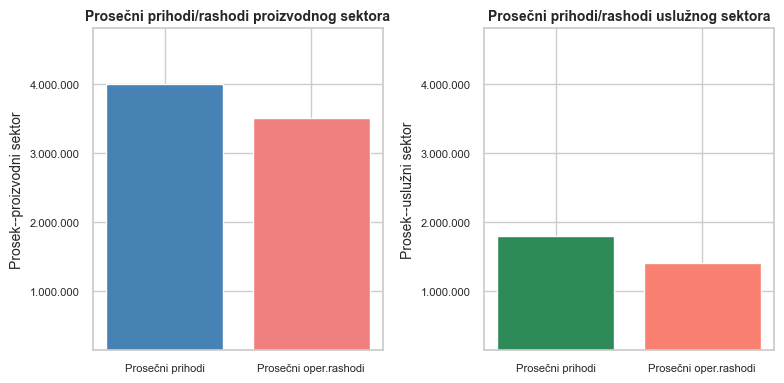

In [1458]:
kategorije = ['Prosečni prihodi', 'Prosečni oper.rashodi']

proizv_data = [
    proiz_sektor_df['prosecni_prihod'].mean(), 
    proiz_sektor_df['prosecni_operativni_rashodi'].mean()
]

usluz_data = [
    usluz_sektor_df['prosecni_prihod'].mean(),
    usluz_sektor_df['prosecni_operativni_rashodi'].mean()
]

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].bar(kategorije, proizv_data, color=['steelblue', 'lightcoral'])
axes[0].set_ylabel('Prosek--proizvodni sektor', fontsize=10)
axes[0].set_title('Prosečni prihodi/rashodi proizvodnog sektora', fontsize=10, fontweight='bold')

axes[0].yaxis.set_major_formatter(FuncFormatter(thousands_separator))

axes[0].tick_params(axis='x', labelsize=8)
axes[0].tick_params(axis='y', labelsize=8)

axes[1].bar(kategorije, usluz_data, color=['seagreen', 'salmon'])
axes[1].set_ylabel('Prosek--uslužni sektor', fontsize=10)
axes[1].set_title('Prosečni prihodi/rashodi uslužnog sektora', fontsize=10, fontweight='bold')

axes[1].yaxis.set_major_formatter(FuncFormatter(thousands_separator))

axes[1].tick_params(axis='x', labelsize=8)
axes[1].tick_params(axis='y', labelsize=8)

y_min = min(min(proizv_data)-(min(proizv_data)*0.9), min(usluz_data)-(min(usluz_data)*0.9))
y_max = max(max(proizv_data)+(max(proizv_data)*0.2), max(usluz_data)+(max(usluz_data)*0.2))
axes[0].set_ylim(y_min, y_max)
axes[1].set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()


Provera uticaja ekstremnih vrednosti

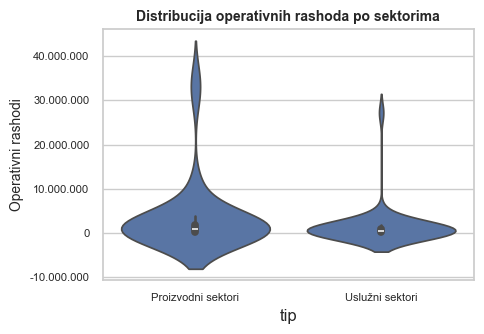

In [1459]:
df_plot = pd.concat([
    proiz_sektor_df.assign(tip='Proizvodni sektori'),
    usluz_sektor_df.assign(tip='Uslužni sektori')
])

plt.figure(figsize=(5, 3.5))
sns.violinplot(data=df_plot, x='tip', y='prosecni_operativni_rashodi', scale='width')
plt.ylabel('Operativni rashodi', fontsize=10)
plt.title('Distribucija operativnih rashoda po sektorima', fontsize=10, fontweight='bold')
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='y')

plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_separator))

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()


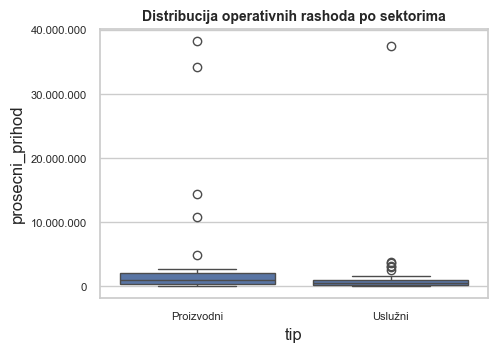

In [1460]:
df_plot = pd.concat([
    proiz_sektor_df.assign(tip='Proizvodni'),
    usluz_sektor_df.assign(tip='Uslužni')
])

plt.figure(figsize=(5, 3.5))
sns.boxplot(data=df_plot, x='tip', y='prosecni_prihod')
plt.title('Distribucija operativnih rashoda po sektorima', fontsize=10, fontweight='bold')

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_separator))

plt.show()

4.B.10. Pregled informacija izabranog sektoru

Detaljan uvid u podatke o određenom sektoru na tržištu. Korišćenjem šifre sektora dobijaju se specifične informacije kao što su udeo prihoda, broj zaposlenih i broj kompanija koje pripadaju tom sektoru. Kroz vizualizaciju, prikazuju se komparativni podaci o tom sektoru u odnosu na celokupno tržište, kako bi se stekao bolji uvid u njegovu relativnu veličinu i značaj u ekonomiji. Analiza uključuje prikaz tržišnih udela u prihodima, broju zaposlenih i broju kompanija, kao i udelu neto marže sektora, što omogućava dublje razumevanje pozicije sektora i njegove efikasnosti.

Pretraga šifre sektora (unesi parcijalni naziv sektora)

In [1461]:
kriterijum_pretrage = 'prog'
# Unesi parcijalni deo naziva sektora za dobijanje šifre sektora


filtered_sektori = sektor_df[sektor_df['opis'].str.contains(kriterijum_pretrage, case=False, na=False)]

for sektor in filtered_sektori.iterrows():
    print(f"NAZIV SEKTORA: {sektor[1]['opis'].split(') ')[1]}, ŠIFRA SEKTORA: {sektor[1]['sektor']}")

NAZIV SEKTORA: Računarsko programiranje, ŠIFRA SEKTORA: 62
NAZIV SEKTORA: Programske aktivnosti i emitovanje, ŠIFRA SEKTORA: 60


Unos šifre izabranog sektora

In [1462]:
sifra_sektora = 62
# Unesi šifru sektora


sifra_sektora = str(sifra_sektora)
cond_sektor = False

if len(sifra_sektora) == 1:
    sifra_sektora = '0' + sifra_sektora

if sifra_sektora in sektor_df['sektor'].astype(str).values:
    cond_sektor = True
    print("Sektor je izabran, pokreni ostale ćelije za osnovne informacije o sektoru")
else:
    print("Ne postoji sektor sa ovom šifrom")

udeo_prihoda = 0
udeo_zaposlenih = 0
broj_kompanija_sektora = 0
broj_kompanija = 0

if cond_sektor:
    ukupni_prihod = df_analysis['prihod'].sum()
    prihod_sektora = sektor_df.loc[sektor_df['sektor'].astype(str) == sifra_sektora, 'ukupni_prihod'].values[0]
    udeo_prihoda = float(round(prihod_sektora / ukupni_prihod, 2))

    ukupni_zaposleni = df_analysis['broj_zaposlenih'].sum()
    zaposleni_sektora = sektor_df.loc[sektor_df['sektor'].astype(str) == sifra_sektora, 'broj_zaposlenih'].values[0]
    udeo_zaposlenih = float(round(zaposleni_sektora / ukupni_zaposleni, 2))

    broj_kompanija = df_analysis.shape[0]
    broj_kompanija_sektora = sektor_df.shape[0]

Sektor je izabran, pokreni ostale ćelije za osnovne informacije o sektoru


Udeo sektora na tržištu po prihodima, broju zaposlenih i broju kompanija

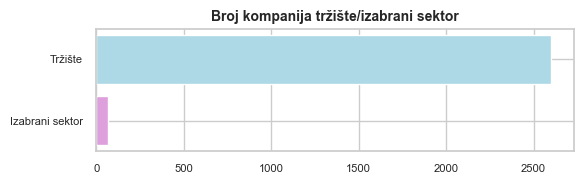

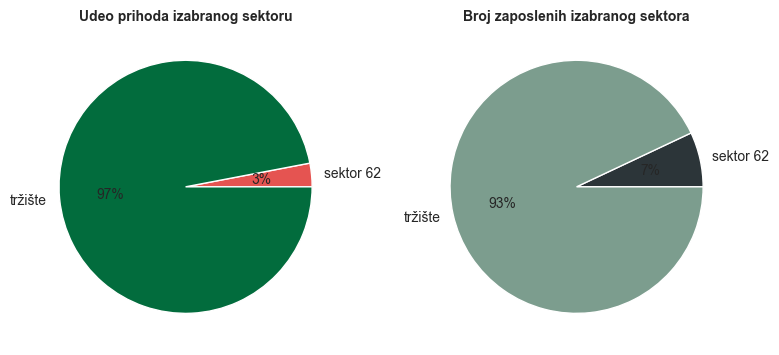

In [1463]:
if cond_sektor:

    plt.figure(figsize=(6, 2))
    plt.barh(['Izabrani sektor', 'Tržište'], [broj_kompanija_sektora, broj_kompanija], color=['#DDA0DD', '#ADD8E6'])
    plt.title('Broj kompanija tržište/izabrani sektor', fontsize=10, fontweight='bold')

    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    plt.tight_layout()
    plt.show()


    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    axs[0].pie([udeo_prihoda, 1-udeo_prihoda], labels=[f'sektor {sifra_sektora}', 'tržište'], autopct='%1.0f%%', colors=['#E55451', '#026C3D'], textprops={'fontsize': 10})
    axs[0].set_title('Udeo prihoda izabranog sektoru', fontsize=10, fontweight='bold')

    axes[0].tick_params(axis='x', labelsize=8)
    axes[0].tick_params(axis='y', labelsize=8)

    axs[1].pie([udeo_zaposlenih, 1-udeo_zaposlenih], labels=[f'sektor {sifra_sektora}', 'tržište'], autopct='%1.0f%%', colors=['#2C3539', '#7C9D8E'], textprops={'fontsize': 10})
    axs[1].set_title('Broj zaposlenih izabranog sektora', fontsize=10, fontweight='bold')

    axes[1].tick_params(axis='x', labelsize=8)
    axes[1].tick_params(axis='y', labelsize=8)

    plt.tight_layout()
    plt.show()
else:
    print("Analiza sektora obustavljena, ne postoji sektor sa ovom šifrom")

Vrednost neto marže izabranog sektora

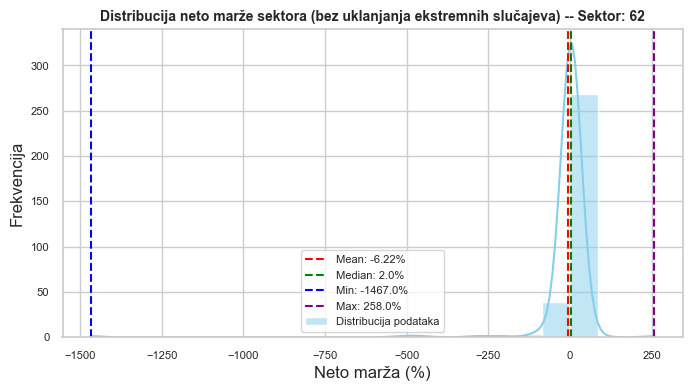

In [1464]:
if cond_sektor:
    data = df_analysis[df_analysis["sektor"] == sifra_sektora]["net_marza"]

    data_percentage = data * 100 

    mean_value = data_percentage.mean()
    median_value = data_percentage.median()
    min_value = data_percentage.min()
    max_value = data_percentage.max()

    plt.figure(figsize=(8, 4))
    sns.histplot(data_percentage, kde=True, color='skyblue', bins=20, label="Distribucija podataka")

    plt.axvline(mean_value, color='red', linestyle='--', label=f'Mean: {round(mean_value, 2)}%')
    plt.axvline(median_value, color='green', linestyle='--', label=f'Median: {round(median_value, 2)}%')
    plt.axvline(min_value, color='blue', linestyle='--', label=f'Min: {round(min_value, 2)}%')
    plt.axvline(max_value, color='purple', linestyle='--', label=f'Max: {round(max_value, 2)}%')

    plt.legend(fontsize=8)
    plt.title(f'Distribucija neto marže sektora (bez uklanjanja ekstremnih slučajeva) -- Sektor: {sifra_sektora}', fontsize=10, fontweight='bold')
    plt.xlabel('Neto marža (%)')  
    plt.ylabel('Frekvencija')

    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    plt.show()
else:
    print("Analiza sektora obustavljena, ne postoji sektor sa ovom šifrom")

Lista 10 kompanija izabranog sektora sa najvećim prihodima

In [1465]:
if cond_sektor:
    df_analysis_sorted = df_analysis.sort_values(by='prihod', ascending=False)

    for i, row in df_analysis_sorted.head(10).iterrows():
        print(f"Naziv: {row['naziv']}, Prihod: {row['prihod']:,.0f} (000 RSD), Neto marža: {row['net_marza']*100:.2f}%")
else:
    print("Analiza sektora obustavljena, ne postoji sektor sa ovom šifrom")    

Naziv: MERCATA VT DOO, Prihod: 873,468,900 (000 RSD), Neto marža: 1.00%
Naziv: APTIV MOBILITY SERVICES DOO, Prihod: 222,077,949 (000 RSD), Neto marža: 4.00%
Naziv: GASTRANS D.O.O. NOVI SAD, Prihod: 207,061,528 (000 RSD), Neto marža: 20.00%
Naziv: IM MATIJEVIĆ DOO NOVI SAD, Prihod: 200,362,116 (000 RSD), Neto marža: 5.00%
Naziv: NAFTAGAS-NAFTNI SERVISI DOO NOVI SAD, Prihod: 142,235,928 (000 RSD), Neto marža: 0.00%
Naziv: KOTEKS VISCOFAN DOO, Prihod: 111,122,156 (000 RSD), Neto marža: 26.00%
Naziv: DOO KONZUL NOVI SAD, Prihod: 109,685,646 (000 RSD), Neto marža: -2.00%
Naziv: GAT DOO NOVI SAD, Prihod: 96,969,189 (000 RSD), Neto marža: 5.00%
Naziv: TRANSPORTGAS SRBIJA DOO NOVI SAD, Prihod: 80,474,264 (000 RSD), Neto marža: 13.00%
Naziv: DOO PIONIR INTERNACIONAL NOVI SAD, Prihod: 74,455,688 (000 RSD), Neto marža: 11.00%


Korelacija finansijskih varijabli izabranog sektora

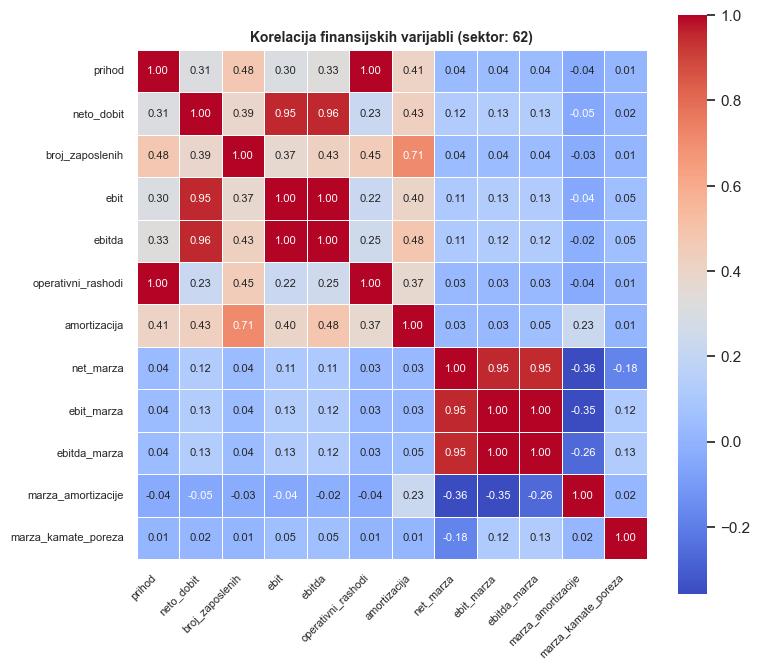

In [1466]:
hm_sektor = df_analysis[df_analysis['sektor'] == sifra_sektora]

hm_kolone = [
    'prihod',
    'neto_dobit',
    'broj_zaposlenih',
    'ebit',
    'ebitda',
    'operativni_rashodi',
    'amortizacija',
    'net_marza',
    'ebit_marza',
    'ebitda_marza',
    'marza_amortizacije',
    'marza_kamate_poreza'
]
hm_sektor = hm_sektor[hm_kolone]

correlation_matrix = hm_sektor.corr()
plt.figure(figsize=(8, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'shrink': 0.8},
    square=True,
    annot_kws={"size": 8}
)

plt.title(f'Korelacija finansijskih varijabli (sektor: {sifra_sektora})', fontsize=10, fontweight='bold')
plt.xticks(fontsize=8, rotation=45, ha='right')
plt.yticks(fontsize=8, rotation=0)
plt.tight_layout()
plt.show()

ZAKLJUČAK:
Analiza sektora i prikaz distribucije podataka pružaju osnovni uvid u tržište novosadskih kompanija, ali istovremeno ukazuju da je za preciznije i dublje uvide neophodna detaljna analiza pojedinačnih sektora ili tržišnih segmenata.

In [1467]:
### čišćenje memorije
# del sektor_df

#### 4.C PRIHODI

4.C.1 Logaritamski raspoređena distribucija prihoda po intervalima

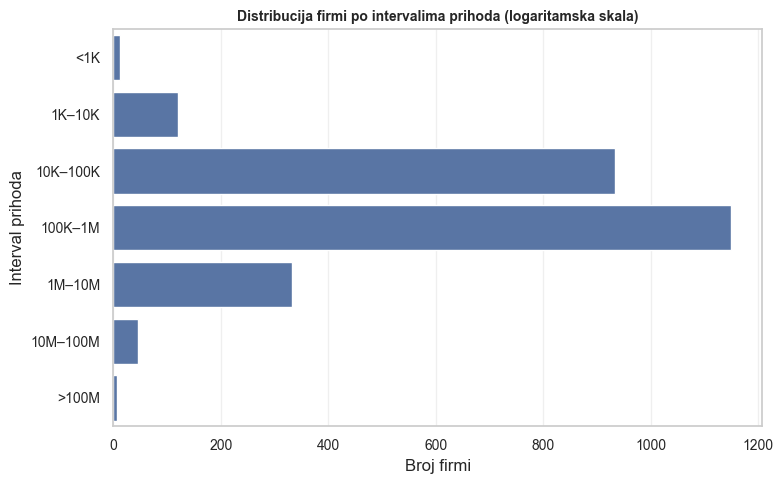

In [1481]:
bins = [0, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9]
labels = ['<1K', '1K–10K', '10K–100K', '100K–1M', '1M–10M', '10M–100M', '>100M']

prihodi_bin_counts = pd.cut(df_analysis['prihod'], bins=bins, labels=labels, include_lowest=True).value_counts().sort_index()

plt.figure(figsize=(8, 5))
sns.barplot(x=prihodi_bin_counts.values, y=prihodi_bin_counts.index, orient='h')
plt.xlabel('Broj firmi')
plt.ylabel('Interval prihoda')
plt.title('Distribucija firmi po intervalima prihoda (logaritamska skala)', fontsize=10, fontweight='bold')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


4.A.2 (ANOVA) Prihodi prema veličini kompanije

Prihod se analizira u odnosu na veličinu kompanije kako bi se utvrdilo da li postoje značajne razlike u distribuciji prihoda između različitih kategorija veličine. Za procenu povezanosti koristi se jednofaktorska analiza varijanse (ANOVA), dok se raspodela vizualizuje putem box plotova.

Nulta hipoteza (H₀): Nema značajne razlike u prihodima između različitih kategorija veličine kompanija.

Alternativna hipoteza (H₁): Postoje značajne razlike u prihodima između različitih kategorija veličine kompanija.

In [1469]:
df_analysis['velicina_kod'] = df_features['velicina'].map({'Mikro': 0, 'Malo': 1, 'Srednje': 2, 'Veliko': 3})
grupe = [grupa['prihod'].values for _, grupa in df_analysis.groupby('velicina_kod')]

# # ANOVA test
f_stat, p_value = f_oneway(*grupe)
print(f"F-statistika: {f_stat:.2f}, p-vrednost: {p_value:.2f}")

print()

# Za utvrđivanje pravca povezanosti
print(df_analysis.groupby('velicina_kod')['prihod'].mean())

F-statistika: 456.14, p-vrednost: 0.00

velicina_kod
0      228261.31
1     2639580.98
2    19275068.61
3   144528205.00
Name: prihod, dtype: float64


Zaključak: 

Pošto je dobijena p-vrednost manja od 0.05 (p = 0.00), odbacujemo nultu hipotezu i zaključujemo da postoje statistički značajne razlike u prihodima između različitih kategorija veličine kompanija.

Srednje vrednosti pokazuju da prihodi rastu sa veličinom kompanije, što ukazuje na pozitivan odnos između veličine firme i ostvarenog prihoda.

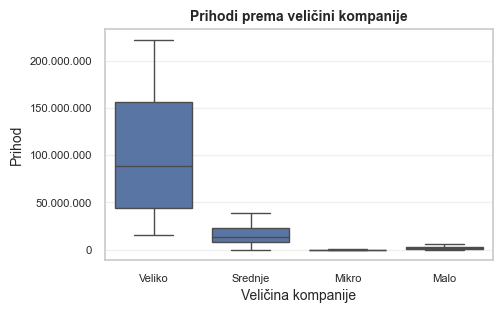

In [1470]:
outliers_prihoda = False  # Isključivanje/uključivanje ekstremnih vrednosti u vizuelizaciji

plt.figure(figsize=(5, 3)) 
sns.boxplot(x='velicina', y='prihod', data=df_analysis, showfliers=outliers_prihoda) 

plt.xlabel('Veličina kompanije', fontsize=10)
plt.ylabel('Prihod', fontsize=10)
plt.title('Prihodi prema veličini kompanije', fontsize=10, fontweight='bold')

plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.gca().yaxis.get_major_formatter().set_scientific(False)

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid(axis='y', alpha=0.3)

plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_separator))

plt.show()

4.C.3 Povezanost prihoda i broja zaposlenih

Prihod se analizira u odnosu na broj zaposlenih kako bi se utvrdilo postoji li povezanost između broja zaposlenih i visine prihoda kompanije. Za ovu analizu koristi se linearna regresija, koja testira da li postoji linearan odnos između ove dve varijable. Uz regresiju, biće korišćen i scatter plot za vizualizaciju odnosa između broja zaposlenih i prihoda. Ukoliko se pokaže značajna povezanost, biće moguće doneti zaključke o tome kako promene u broju zaposlenih utiču na prihode.

Nulta hipoteza (H₀): Nema linearne povezanosti između broja zaposlenih i prihoda.

Alternativna hipoteza (H₁): Postoji linearna povezanost između broja zaposlenih i prihoda.

In [1471]:
lr_model = LinearRegression()

# Treniranje modela
lr_model.fit(df_analysis[['broj_zaposlenih']], df_analysis['prihod'])

# Predikcija
predicted = lr_model.predict(df_analysis[['broj_zaposlenih']])

# Prikazivanje koeficijenata
print(f'Koeficijent: {lr_model.coef_[0]:.2f}')
print(f'Intercept: {lr_model.intercept_:.2f}')

Koeficijent: 97182.58
Intercept: 572169.56


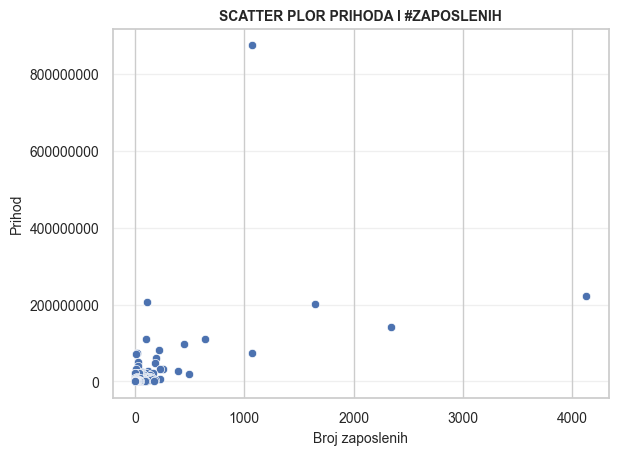

In [1472]:
sns.scatterplot(x='broj_zaposlenih', y='prihod', data=df_analysis)

plt.xlabel('Broj zaposlenih', fontsize=10)
plt.ylabel('Prihod', fontsize=10)
plt.title('SCATTER PLOR PRIHODA I #ZAPOSLENIH', fontsize=10, fontweight='bold')

plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.gca().yaxis.get_major_formatter().set_scientific(False)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', alpha=0.3)

plt.show()

Zaključak

Na osnovu rezultata linearne regresije, utvrđeno je da prihod kompanije u proseku raste sa porastom broja zaposlenih. Pozitivan koeficijent ukazuje na to da svaki dodatni zaposleni doprinosi povećanju prihoda, dok intercept označava procenjeni prihod kada kompanija nema zaposlenih.

Ova pozitivna linearna povezanost sugeriše da postoji jasan trend rasta prihoda u skladu sa povećanjem radne snage.

Nulta hipoteza (H₀): Ne postoji linearna povezanost između broja zaposlenih i prihoda.
Alternativna hipoteza (H₁): Postoji linearna povezanost između broja zaposlenih i prihoda.

Na osnovu rezultata regresione analize, nulta hipoteza se odbacuje u korist alternativne, što upućuje na postojanje statistički značajne linearne povezanosti između ova dva faktora.

4.C.4 Identifikacija sektora sa najnižim i najvišim prihodima

U ovoj analizi posmatra se raspodela prihoda po različitim vrstama sektora poslovanja kako bi se identifikovali sektori sa najvećim i najmanjim prihodima.

In [1473]:
print('SEKTORI SA NAJVEÇIM PRIHODIMA:')
print()

top5_sektora = (
    df_analysis.groupby('sektor')['prihod']
    .mean()
    .sort_values(ascending=False)
    .head(5)
    .reset_index()
)
company_count = df_analysis.groupby('sektor')['prihod'].count().reset_index(name='company_count')

top5_sektora = top5_sektora.merge(delatnosti_df, left_on='sektor', right_on='sifra', how='left')
top5_sektora = top5_sektora.merge(company_count, on='sektor', how='left')

top5_sorted = top5_sektora.sort_values(by='prihod', ascending=False)

for i, row in top5_sorted.iterrows():
    print(f"- Sektor {row['sektor']} ({row['opis']}):\n"
          f"  Prosečan prihod: {round(row['prihod'], 2)}\n"
          f"  Broj kompanija: {row['company_count']}\n")

SEKTORI SA NAJVEÇIM PRIHODIMA:

- Sektor 27 (Proizvodnja električne opreme):
  Prosečan prihod: 38268809.67
  Broj kompanija: 6

- Sektor 92 (Kockanje i klađenje):
  Prosečan prihod: 37444141.0
  Broj kompanija: 2

- Sektor 09 (Uslužne delatnosti u rudarstvu i geološkim istraživanjima):
  Prosečan prihod: 34258171.8
  Broj kompanija: 5

- Sektor 32 (Ostale prerađivačke delatnosti):
  Prosečan prihod: 14413481.0
  Broj kompanija: 8

- Sektor 10 (Proizvodnja prehrambenih proizvoda):
  Prosečan prihod: 10741965.46
  Broj kompanija: 28



In [1474]:
print('SEKTORI SA NAJMANJIM PRIHODIMA:')
print()

bottom5_sektora = (
    df_analysis.groupby('sektor')['prihod']
    .mean()
    .sort_values(ascending=False)
    .tail(5)
    .reset_index()
)

company_count = df_analysis.groupby('sektor')['prihod'].count().reset_index(name='company_count')

bottom5_sektora = bottom5_sektora.merge(delatnosti_df, left_on='sektor', right_on='sifra', how='left')
bottom5_sektora = bottom5_sektora.merge(company_count, on='sektor', how='left')

top5_sorted = bottom5_sektora.sort_values(by='prihod', ascending=True)

for i, row in top5_sorted.iterrows():
    print(f"- Sektor {row['sektor']} ({row['opis']}):\n"
          f"  Prosečan prihod: {round(row['prihod'], 2)}\n"
          f"  Broj kompanija: {row['company_count']}\n")

SEKTORI SA NAJMANJIM PRIHODIMA:

- Sektor 15 (Proizvodnja kože i predmeta od kože):
  Prosečan prihod: 25424.0
  Broj kompanija: 1

- Sektor 88 (Socijalna zaštita bez smeštaja):
  Prosečan prihod: 34084.5
  Broj kompanija: 2

- Sektor 30 (Proizvodnja ostalih saobraćajnih sredstava):
  Prosečan prihod: 43216.0
  Broj kompanija: 1

- Sektor 50 (Vodeni saobraćaj):
  Prosečan prihod: 67175.0
  Broj kompanija: 2

- Sektor 96 (Ostale lične uslužne delatnosti):
  Prosečan prihod: 79980.39
  Broj kompanija: 23



4.C.5. Analiza izolovanih slučajeva (outlier amaliza)

#### 4.D RASHODI

4.D.1 Logaritamski raspoređena distribucija operativnih rasphoda po intervalima

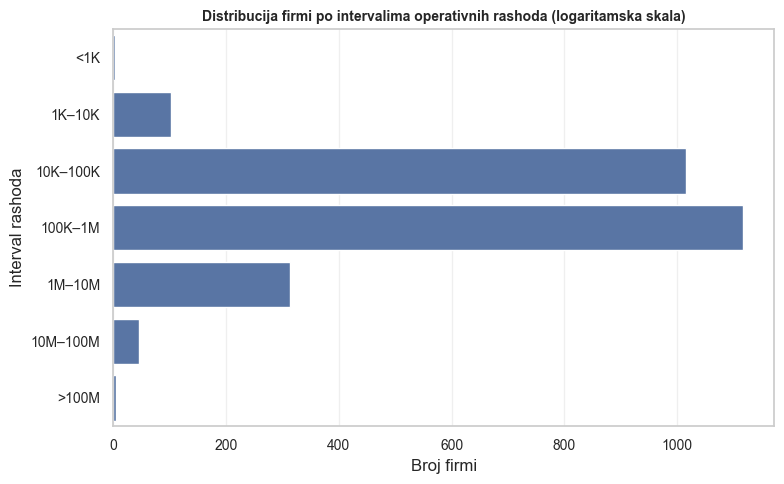

In [1485]:
bins = [0, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9]
labels = ['<1K', '1K–10K', '10K–100K', '100K–1M', '1M–10M', '10M–100M', '>100M']

rashodi_bin_counts = pd.cut(df_analysis['operativni_rashodi'], bins=bins, labels=labels, include_lowest=True).value_counts().sort_index()

plt.figure(figsize=(8, 5))
sns.barplot(x=rashodi_bin_counts.values, y=rashodi_bin_counts.index, orient='h')
plt.xlabel('Broj firmi')
plt.ylabel('Interval rashoda')
plt.title('Distribucija firmi po intervalima operativnih rashoda (logaritamska skala)', fontsize=10, fontweight='bold')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


#### 4.E NETO DOBIT

#### 4.E POSLOVNE MARŽE

#### 4.F AMORTIZACIJA I MARŽA AMORTIZACIJE

#### 4.G ZAPOSLENI

#### 4.I OSTALO (komparativna analiza)

#### 5. Klaster analiza.

Priprema i enkodiranje podataka